# Setup

In [7]:
import contracts
contracts.disable_all()

In [21]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html
import geometry as g
import numpy as np
import networkx as nx
import copy

In [9]:
dw.logger.setLevel(50)

Better visualization of output

In [10]:
%%html
<style>
pre {line-height: 90%}
</style>

# Road Network
Let's load a map and compute the road network.

In [11]:
m = dw.load_map('4way')


Use the function `get_skeleton_graph`:

In [12]:
sk = dw.get_skeleton_graph(m)

The return type is `SkeletonGraphResult`. It contains in `sk.root2` a new map with the joined lane segments. 

In [13]:
ipython_draw_html(sk.root2);

While in the attribute `sk.G` we find a graph describing the topology.

This is a graph where each node is a meeting point between lanes, and each edge represents a lane.

In [32]:
import sys
sys.path.append("/home/jose/code/duckietown/duckietown-uplan/lib-uplan/")
import utils.augmentation as aug

aug_graph = augment_graph(sk.G, num_right=2, num_left=2)

In [15]:
def add_point_horizontally(point, dist):
    """ Takes a distance and a point and shifts the point to the
    left relative to his original position
    point: SE2Transform
    dist: float
    """
    shift_mat = g.SE2_from_rotation_translation(np.eye(2), np.array([0, dist]))
    point_mat = point.asmatrix2d().m
    shifted = np.dot(point_mat, shift_mat)
    return dw.geo.SE2Transform.from_SE2(shifted)

In [31]:
def augment_graph(graph, num_right=3, num_left=1, dist=0.1):

    aug_graph = copy.deepcopy(graph)

    # Add an augmented state for the graph
    for n in aug_graph.nodes():
        aug_graph.nodes[n]['visited'] = False

    first_node = list(graph.nodes())[0]
    to_visit_stack = [first_node, ]

    while True:
        if not to_visit_stack:
            break

        current_node = to_visit_stack.pop()

        # Add not visited successors to stack
        for suc in nx.DiGraph.successors(graph, current_node):
            if not aug_graph.node[suc]['visited']:
                to_visit_stack.append(suc)

        if not aug_graph.node[current_node]['visited']:
            
            current_point = aug_graph.node[current_node]['point']
            
            aug_graph.add_node(current_node + "_l")
            aug_graph.add_node(current_node + "_r")
            aug_graph.node[current_node + "_l"]['point'] = add_point_horizontally(current_point, -dist)
            aug_graph.node[current_node + "_r"]['point'] = add_point_horizontally(current_point, dist)
            
            for predec in nx.DiGraph.predecessors(graph, current_node):
                # Add edges from parent to new neighbors
                aug_graph.add_edge(predec, current_node + "_l")
                aug_graph.add_edge(predec, current_node + "_r")
                if aug_graph.node[predec]['visited']:
                    aug_graph.add_edge(predec + "_r", current_node + "_r")
                    aug_graph.add_edge(predec + "_l", current_node + "_l")
                    aug_graph.add_edge(predec + "_r", current_node)
                    aug_graph.add_edge(predec + "_l", current_node)
            
            # Check if succesors are visited and add nodes from new neighbors to their neighbors
            for suc in nx.DiGraph.successors(graph, current_node):
                if aug_graph.node[suc]['visited']:
                    aug_graph.add_edge(current_node + "_r", suc + "_r")
                    aug_graph.add_edge(current_node + "_l", suc + "_l")
                    aug_graph.add_edge(current_node + "_r", suc)
                    aug_graph.add_edge(current_node + "_l", suc)
                    
        aug_graph.node[current_node]['visited'] = True

    return aug_graph

Let's bring in the `draw_graph` function from some time ago.

In [27]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={}, node_size=10) # node:node for node in G0.nodes()
    nx.draw_networkx_edge_labels(G0,pos,edge_labels={},font_color='red')
    plt.axis('off')
    plt.show()

Set the position of each node in the graph based on the attribute 'point'.

In [29]:
%matplotlib inline

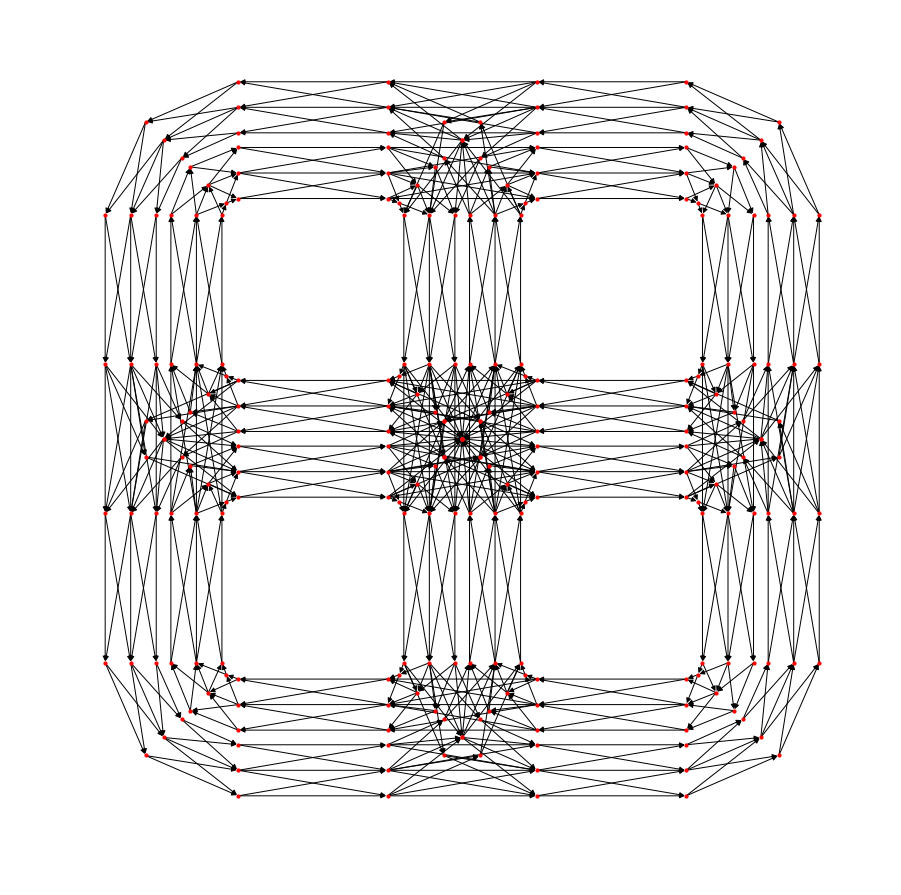

In [33]:
import geometry as geo
pos = {}
for n in aug_graph:
    q = aug_graph.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(aug_graph, pos=pos)

We find the shortest path:

In [ ]:
import networkx as nx
path = nx.shortest_path(sk.G, start, end)
print(path)